In [1]:
import numpy as np
import pandas as pd
import plotly
import ipywidgets as widgets
from ipywidgets import interact
from gurobipy import *
from scipy.spatial import distance
import matplotlib.pyplot as plt
import random
from random import choices
from math import radians, cos, sin, asin, sqrt

In [17]:
#choose your insitution
print('Please choose your Insitution')
institutions = ['Vassar College', 'Bard College', 'SUNY New Paltz', 'Woodland Pond']
farms = ['Hearty Roots Community Farm', 'Taliaferro Farms', 'Alewife Farm', 'Poughkeepsie Farm Project', 'Sparrowbush Farm',
        'Evolutionary Organics', 'Huguenot Street Farm', 'Letterbox Farm', 'Second Wind CSA', 'Solid Ground Farm']
inst_dropdown = widgets.Dropdown(options = institutions)
display(inst_dropdown)

#choose demand of insitution
options=list(range(10))

widget1 = widgets.Dropdown(options = options)
widget2 = widgets.Dropdown(options = options)
widget3 = widgets.Dropdown(options = options)
widget4 = widgets.Dropdown(options = options)
widget5 = widgets.Dropdown(options = options)
widget6 = widgets.Dropdown(options = options)             

def printer(tomatoes, beans, cucumber, zucchini, lettuce, squash):
    print(tomatoes, beans, cucumber, zucchini, lettuce, squash)
  #  return [tomatoe, beans, cucumber, zucchini, lettuce, squash]
    

print('Please enter your order')
interact(printer, tomatoes = widget1,
                beans = widget2,
                cucumber = widget3, 
                zucchini = widget4, 
                lettuce = widget5,
                squash = widget6);


Please choose your Insitution


A Jupyter Widget

Please enter your order


A Jupyter Widget

In [48]:
#save institution
institution = inst_dropdown.value
print('Insitution: '+ str(institution))

#save demand
demand_array = [widget1.value, widget2.value, widget3.value, widget4.value, widget5.value, widget6.value]
demand = []
for widget in range(len(demand_array)):
    inter = []
    #demand = list(widget)
    if demand_array[widget] > 0:
        inter.append(demand_array[widget])
        demand.append(inter)
    else:
        inter.append(1000)
        demand.append(inter)
print('Demand:' + str(demand))



Insitution: Vassar College
Demand:[[1], [9], [9], [9], [9], [1000]]


In [49]:
no_facilities = 10
no_customers = 4
products = ['tomatoes', 'beans', 'cucumbers', 'zucchini', 'lettuce', 'squash']
population = list(range(10))
weights = [0.4, 0.2, 0.1, 0.1, 0.05, 0.05, 0.025, 0.025, 0.025, 0.025]

In [50]:
def initializeData( inputFile ):
    file = open( inputFile , "r" )
    contents = file.readlines()
    length = len( contents )
    table = [ 0 for i in range( length )]
    for i in range( length ):
        table[ i ] = contents[ i ].split()
    noFarms_ = int( table[ 0 ][ 0 ] )
    noInst_ = int( table[ 0 ][ 1 ] )
    
    lineNo = 1
    coordinates_farms_ = [ [ 0 for n in range(2) ] for i in range( noFarms_) ]
    for i in range( noFarms_ ):
        coordinates_farms_[ i ][ 0 ] = float( table[ lineNo ][ 0 ] )
        coordinates_farms_[ i ][ 1 ] = float( table[ lineNo ][ 1 ] )
        lineNo += 1

    #rand = random.randint(0,3)
    coordinates_inst_ = [ 0 for n in range(2)  ]
    coordinates_inst_[ 0 ] = float( table[ lineNo + institutions.index(institution) ][ 0 ] )
    coordinates_inst_[ 1 ] = float( table[ lineNo + institutions.index(institution) ][ 1 ] )
    
    return ( noFarms_ , coordinates_farms_, coordinates_inst_)

def dist_matrix():
    global noFarms, coordinates_farms, coordinates_inst
    dist_matrix_ = [0 for i in range(noFarms)]
    for i in range(noFarms):    
        # convert decimal degrees to radians 
        lon1, lat1, lon2, lat2 = map(radians, [coordinates_farms[i][1], coordinates_farms[i][0], coordinates_inst[1], coordinates_inst[0]])
        # haversine formula 
        dlon = lon2 - lon1 
        dlat = lat2 - lat1 
        a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
        c = 2 * asin(sqrt(a)) 
        # Radius of earth in kilometers is 6371
        d = 6371* c
        dist_matrix_[i] = d

    return dist_matrix_

def create_supply_matrix ():
    global noFarms, coordinates_farms, coordinates_inst
    supply_matrix_ = [[0 for j in range(noFarms)] for i in range(len(products))]
    for i in range(len(products)):
        for j in range(noFarms):    
            rand = choices(population, weights) 
            supply_matrix_[i][j] = rand
    return supply_matrix_

def create_coverage_matrix():
    global noFarms, coordinates_farms, coordinates_inst
    coverage_matrix_ = [[0 for j in range(noFarms)] for i in range(len(products))]
    for i in range(len(products)):
        for j in range(noFarms):  
            #if demand for the product is greater than 0
            if demand_matrix[i][0] > 0: 
                if supply_matrix[i][j] >= demand_matrix[i]:
                    coverage_matrix_[i][j] = 1
    return coverage_matrix_

def create_model(model_name, constructVars, constructObj, constructConstr):
    global noFarms, products
    #max_farms_model
    ipModel = Model(model_name)
    xVars = [[0 for  i in range(noFarms)] for p in range(len(products))]
    yVars = [0 for  i in range(noFarms)]
    constructVars(ipModel, xVars, yVars)
    constructObj(ipModel, yVars)
    constructConstr(ipModel, xVars, yVars)
    name = 'social_justice_' + str(model_name) + '.lp'
    ipModel.write(name)
    ipModel.optimize()

    myVars = ipModel.getVars()
    vars_list = 'vars_list' + str(model_name)
    vars_list = []
    for curVar in myVars:
        vars_list.append(float(curVar.x))

    vars_matrix = [[0 for j in range(noFarms)] for i in range(len(products))]
    count = 0
    for i in range(len(products)):
        for j in range(noFarms): 
            vars_matrix[i][j] = vars_list[count]
            count +=1
    return vars_matrix, vars_list

#plot graph
def plot (noFarms , coordinates_farms, coordinates_inst, vars_matrix, algorithm):
    plt.figure(figsize = (10,10))
    for i in range(noFarms):
        plt.plot(coordinates_farms[i][0], coordinates_farms[i][1], 'ro', color = 'green', lw = 9)
        plt.text(coordinates_farms[i][0] + 0.005, coordinates_farms[i][1] + 0.005, farms[i], fontsize=12)

    plt.plot(coordinates_inst[0], coordinates_inst[1], 'ro', color = 'red', lw = 9)
    plt.text(coordinates_inst[0] + 0.01, coordinates_inst[1], institution, color = 'red', fontsize=12)

    
    for i in range(len(products)):
        for j in range(noFarms): 
            if vars_matrix[i][j] == 1:
                x_values = [coordinates_farms[j][0], coordinates_inst[0]]
                y_values = [coordinates_farms[j][1], coordinates_inst[1]]
                plt.plot(x_values, y_values)
    plt.title(str(algorithm))
    plt.xlabel('Latitude')
    plt.ylabel('Longitude')
    plt.draw()
    plt.savefig('social_justice_map3.png')
    plt.pause(0.001)

#farms supplying, products supplied, products out of stock, and total distance
def stats (vars_matrix, demand_matrix):
    global products, noFarms
    farms_supplying_ = []
    products_supplied_ = []
    unique_farms_supplying_ = []
    for i in range(len(products)):
        for j in range(noFarms): 
            if vars_matrix[i][j] == 1:
                farms_supplying_.append(j)
                products_supplied_.append(i)
                if j not in unique_farms_supplying_:
                    unique_farms_supplying_.append(j)

    farms_supplying_names_ = []
    for farm in farms_supplying_:
        farms_supplying_names_.append(farms[farm])

    total_distance_ = 0
    for i in unique_farms_supplying_:
        total_distance_ += distance_matrix[i]
    
    prod_not_supplied_ = []
    for prod in range(len(products)):
        if prod not in products_supplied_:
            if demand_matrix[prod][0] != 1000:
                prod_not_supplied_.append(prod)

    return farms_supplying_, products_supplied_, total_distance_ , unique_farms_supplying_, prod_not_supplied_, farms_supplying_names_

def print_solution(vars_matrix, title):
    global noFarms, coordinates_farms, coordinates_inst, demand_matrix
    print('')
    print('--------------------------')
    print(title)
    plot (noFarms, coordinates_farms, coordinates_inst, vars_matrix, title)
    farms_supplying, products_supplied, total_distance, unique_farms_supplying, prod_not_supplied, farms_supplying_names = stats (vars_matrix, demand_matrix)
          
    print('\033[4mShopping List\033[0m')
    for i in range(len(farms_supplying)):
        print('Farm ' + str(farms[farms_supplying[i]]) + ': ' + str(demand[products_supplied[i]][0]) + ' cases of ' + str(products[products_supplied[i]]))
    print('')
    if len(prod_not_supplied) != 0:
        print('\033[4mProducts out of Stock\033[0m')
        for i in prod_not_supplied:
            print(products[i])
    print('')
    print('Number of farms supplying ' + str(len(unique_farms_supplying)))
    print('Total Distance (km) ' + str(total_distance))
    print('')
    

In [51]:
#construct model  max farms
def constructVars_max_farms(ipModel, xVars, yVars):
    global noFarms, products
    for i in range(len(products)):
        for j in range(noFarms):  
            var = ipModel.addVar(vtype = GRB.BINARY, name = "x_product_" + str(i)+ "_farm_" + str(j))
            xVars[i][j] = var

    for j in range(noFarms):  
            var2 = ipModel.addVar(vtype = GRB.BINARY, name = "y_farm_" + str(j))
            yVars[j] = var2
    
    ipModel.update()

#max number of farms
def constructObj_max_farms(ipModel, yVars):
    global noFarms, products, coverage_matrix
    objExpr = LinExpr()
    for j in range(noFarms):  
        objExpr += yVars[j]
    ipModel.setObjective(objExpr, GRB.MAXIMIZE)
    ipModel.update()

#only one farm supplies each product
def constructConstr_max_farms(ipModel, xVars, yVars):
    global noFarms, products, coverage_matrix
    for i in range(len(products)):
        constrExpr = LinExpr()
        for j in range(noFarms):
            constrExpr += 1*xVars[i][j]*coverage_matrix[i][j]
        ipModel.addConstr(lhs = constrExpr, sense = GRB.LESS_EQUAL, rhs = 1, name = "product_" + str(i))

    for j in range(noFarms):
        constrExpr = LinExpr()
        constrExpr += yVars[j]
        for i in range(len(products)):
            constrExpr -= 1*xVars[i][j]*coverage_matrix[i][j]
        ipModel.addConstr(lhs = constrExpr, sense = GRB.LESS_EQUAL, rhs = 0, name = "farm_" + str(j) + "_supplying")



In [52]:
#construct model min farms
def constructVars_min_farms(ipModel, xVars, yVars):
    global noFarms, products
    for i in range(len(products)):
        for j in range(noFarms):  
            var = ipModel.addVar(vtype = GRB.BINARY, name = "x_product_" + str(i)+ "_farm_" + str(j))
            xVars[i][j] = var

    for j in range(noFarms):  
            var2 = ipModel.addVar(vtype = GRB.BINARY, name = "y_farm_" + str(j))
            yVars[j] = var2
    
    ipModel.update()

#max number of farms
def constructObj_min_farms(ipModel, yVars):
    global noFarms, products, coverage_matrix
    objExpr = LinExpr()
    for j in range(noFarms):  
        objExpr += yVars[j]
    ipModel.setObjective(objExpr, GRB.MINIMIZE)
    ipModel.update()

#only one farm supplies each product
def constructConstr_min_farms(ipModel, xVars, yVars):
    global noFarms, products, coverage_matrix
    for i in range(len(products)):
        constrExpr = LinExpr()
        for j in range(noFarms):
            constrExpr += 1*xVars[i][j]*coverage_matrix[i][j]
        ipModel.addConstr(lhs = constrExpr, sense = GRB.LESS_EQUAL, rhs = 1, name = "product_" + str(i))

    for j in range(noFarms):
        constrExpr = LinExpr()
        constrExpr += 100*yVars[j]
        for i in range(len(products)):
            constrExpr -= 1*xVars[i][j]*coverage_matrix[i][j]
        ipModel.addConstr(lhs = constrExpr, sense = GRB.GREATER_EQUAL, rhs = 0, name = "farm_" + str(j) + "_supplying")
    
    for i in range(len(products)):
        constrExpr = LinExpr()
        for j in range(noFarms):
            constrExpr += coverage_matrix[i][j]
            constrExpr -= 100*xVars[i][j]*coverage_matrix[i][j]
        ipModel.addConstr(lhs = constrExpr, sense = GRB.LESS_EQUAL, rhs = 0, name = "demand_" + str(products[i]))
        
    for i in range(len(products)):
        for j in range(noFarms):
            constrExpr = LinExpr()
            constrExpr += xVars[i][j]
            constrExpr -= coverage_matrix[i][j] 
            ipModel.addConstr(lhs = constrExpr, sense = GRB.LESS_EQUAL, rhs = 0, name = "x_product_" + str(i)+ "_farm_" + str(j) + "_less_equal_coverage" )

 

In [53]:
#construct model min_dist
def constructVars_min_dist(ipModel, xVars, yVars):
    global noFarms, products
    for i in range(len(products)):
        for j in range(noFarms):  
            var = ipModel.addVar(vtype = GRB.BINARY, name = "x_product_" + str(i)+ "_farm_" + str(j))
            xVars[i][j] = var

    for j in range(noFarms):  
            var2 = ipModel.addVar(vtype = GRB.BINARY, name = "y_farm_" + str(j))
            yVars[j] = var2
    
    ipModel.update()

#max number of farms
def constructObj_min_dist(ipModel, yVars):
    global noFarms, products, coverage_matrix
    objExpr = LinExpr()
    for j in range(noFarms):  
        objExpr += yVars[j]*distance_matrix[j]
    ipModel.setObjective(objExpr, GRB.MINIMIZE)
    ipModel.update()

#only one farm supplies each product
def constructConstr_min_dist(ipModel, xVars, yVars):
    global noFarms, products, coverage_matrix
    for i in range(len(products)):
        constrExpr = LinExpr()
        for j in range(noFarms):
            constrExpr += 1*xVars[i][j]*coverage_matrix[i][j]
        ipModel.addConstr(lhs = constrExpr, sense = GRB.LESS_EQUAL, rhs = 1, name = "product_" + str(i))

    for j in range(noFarms):
        constrExpr = LinExpr()
        constrExpr += 100*yVars[j]
        for i in range(len(products)):
            constrExpr -= 1*xVars[i][j]*coverage_matrix[i][j]
        ipModel.addConstr(lhs = constrExpr, sense = GRB.GREATER_EQUAL, rhs = 0, name = "farm_" + str(j) + "_supplying")
    
    for i in range(len(products)):
        constrExpr = LinExpr()
        for j in range(noFarms):
            constrExpr += coverage_matrix[i][j]
            constrExpr -= 100*xVars[i][j]*coverage_matrix[i][j]
        ipModel.addConstr(lhs = constrExpr, sense = GRB.LESS_EQUAL, rhs = 0, name = "demand_" + str(products[i]))
        
    for i in range(len(products)):
        for j in range(noFarms):
            constrExpr = LinExpr()
            constrExpr += xVars[i][j]
            constrExpr -= coverage_matrix[i][j] 
            ipModel.addConstr(lhs = constrExpr, sense = GRB.LESS_EQUAL, rhs = 0, name = "x_product_" + str(i)+ "_farm_" + str(j) + "_less_equal_coverage" )

    

Distance matrix [45.14508825437491, 18.056535426213962, 21.895863460102223, 0.9927024881296072, 48.63037249788447, 19.33384431166865, 17.80979654241031, 60.18336530092831, 20.605610077164144, 31.396506062535142]
Demand matrix [[1], [9], [9], [9], [9], [1000]]
Supply matrix [[[0], [0], [5], [0], [2], [5], [3], [3], [2], [2]], [[1], [0], [0], [7], [1], [3], [1], [0], [1], [3]], [[0], [0], [1], [9], [1], [8], [1], [0], [1], [5]], [[3], [0], [0], [2], [6], [2], [1], [1], [1], [0]], [[2], [3], [3], [0], [0], [0], [9], [1], [1], [2]], [[1], [1], [0], [0], [0], [2], [6], [0], [2], [0]]]
Coverage matrix [[0, 0, 1, 0, 1, 1, 1, 1, 1, 1], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 1, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 1, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]
Optimize a model with 16 rows, 70 columns and 28 nonzeros
Variable types: 0 continuous, 70 integer (70 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
 

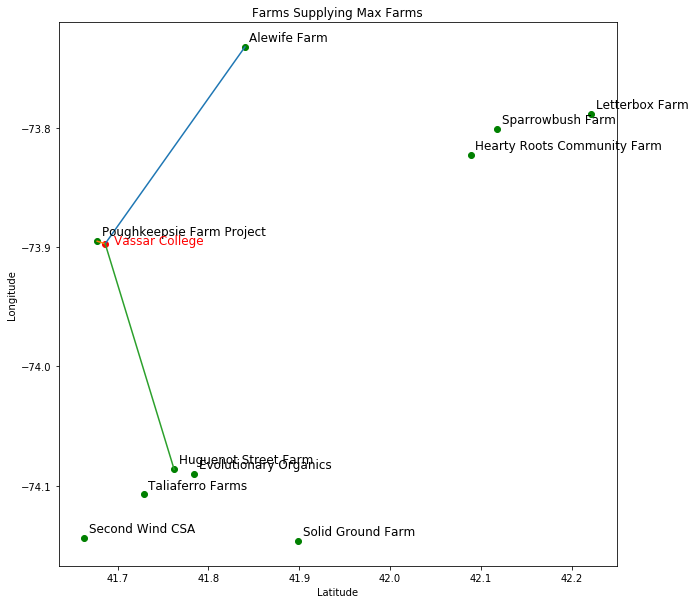

Shopping List
Farm Alewife Farm: 1 cases of tomatoes
Farm Poughkeepsie Farm Project: 9 cases of cucumbers
Farm Huguenot Street Farm: 9 cases of lettuce

Products out of Stock
beans
zucchini

Number of farms supplying 3
Total Distance (km) 40.69836249064214


--------------------------
Farms Supplying Min Farms


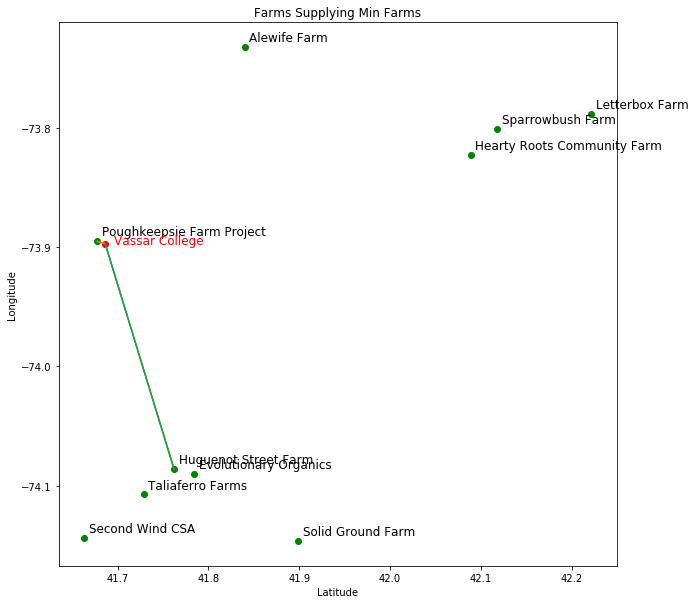

Shopping List
Farm Huguenot Street Farm: 1 cases of tomatoes
Farm Poughkeepsie Farm Project: 9 cases of cucumbers
Farm Huguenot Street Farm: 9 cases of lettuce

Products out of Stock
beans
zucchini

Number of farms supplying 2
Total Distance (km) 18.802499030539916


--------------------------
Farms Supplying Min Distance


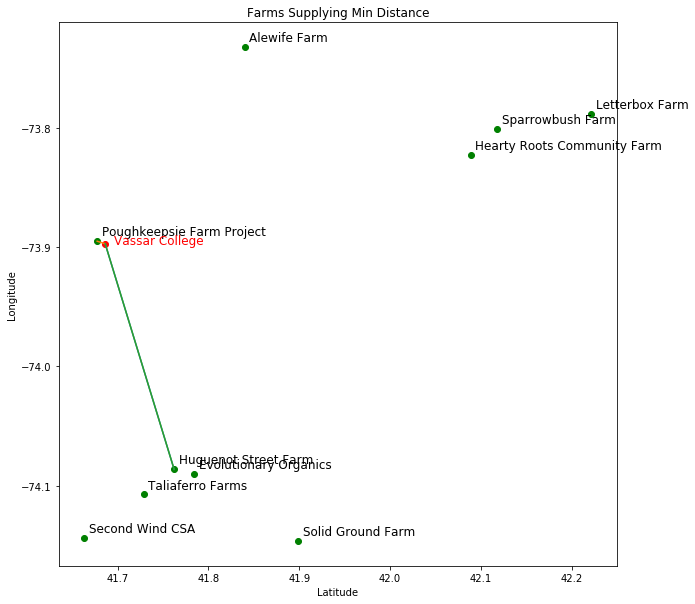

Shopping List
Farm Huguenot Street Farm: 1 cases of tomatoes
Farm Poughkeepsie Farm Project: 9 cases of cucumbers
Farm Huguenot Street Farm: 9 cases of lettuce

Products out of Stock
beans
zucchini

Number of farms supplying 2
Total Distance (km) 18.802499030539916



In [54]:
inFile = "social_justice_1.txt"
noFarms, coordinates_farms, coordinates_inst = initializeData( inFile )
distance_matrix = dist_matrix ()
 
demand_matrix = demand
supply_matrix = create_supply_matrix ()
coverage_matrix = create_coverage_matrix ()
print('Distance matrix ' + str(distance_matrix))
print('Demand matrix ' + str(demand_matrix))
print('Supply matrix ' + str(supply_matrix))
print('Coverage matrix ' + str(coverage_matrix))


vars_matrix_max_farms, vars_list_max_farms = create_model("max_farms", constructVars_max_farms, constructObj_max_farms, constructConstr_max_farms )
vars_matrix_min_farms, vars_list_min_farms = create_model("min_farms", constructVars_min_farms, constructObj_min_farms, constructConstr_min_farms )
vars_matrix_min_dist, vars_list_min_dist = create_model("min_dist", constructVars_min_dist, constructObj_min_dist, constructConstr_min_dist )

print_solution(vars_matrix_max_farms, 'Farms Supplying Max Farms' )
print_solution(vars_matrix_min_farms, 'Farms Supplying Min Farms' )
print_solution(vars_matrix_min_dist, 'Farms Supplying Min Distance' )
            